# Titanic - Machine Learning From Disater - Version2

### import thư viện

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### import dữ liệu

In [3]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df = pd.read_csv('./data/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Exploratory Data Analysis (EDA)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [7]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False).round(2)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data['Total'] > 0]
print(missing_data(train_df))

          Total  Percent
Cabin       687    77.10
Age         177    19.87
Embarked      2     0.22


* Feature Cabin có 687 missing values chiếm 77.10% dữ liệu
* Age có 177 missing values chiếm 19.87% dữ liệu
* Embarked có 2 missing values chiếm 0.22% dữ liệu

Text(0.5, 1.0, 'Survival Distribution')

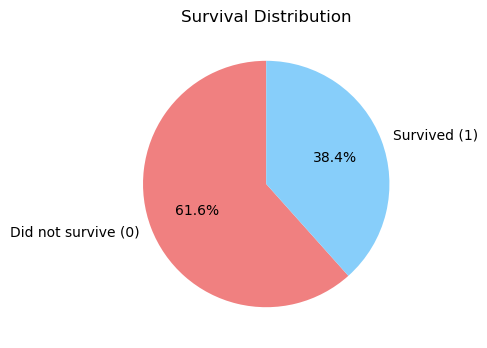

In [8]:
survived_counts = train_df['Survived'].value_counts()
plt.figure(figsize=(6,4))
plt.pie(survived_counts, labels=['Did not survive (0)', 'Survived (1)'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Survival Distribution')

* Ta thấy được ở đây có tỉ lệ người sống sót là 38.4% và còn lại là không thể sống sót

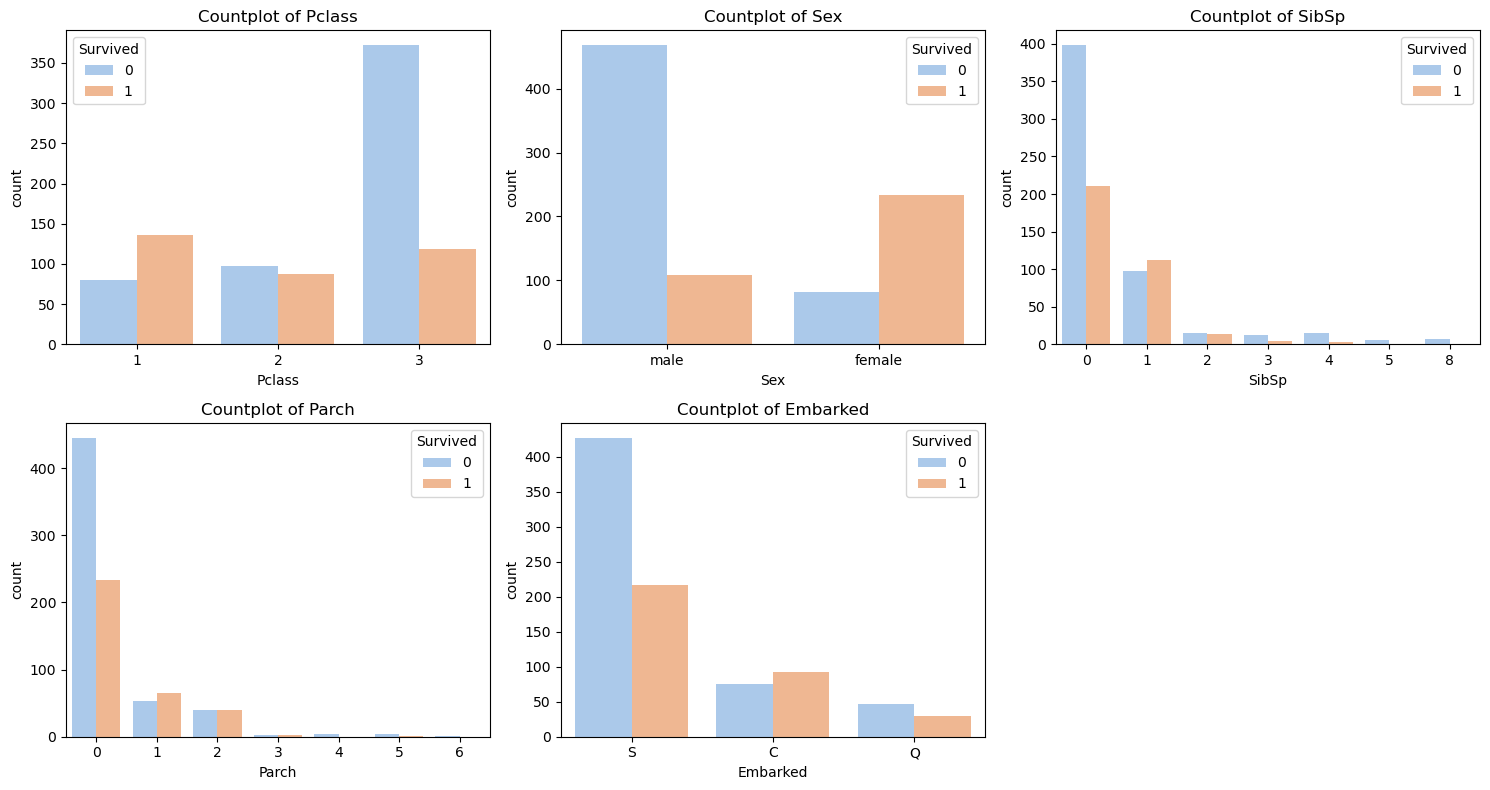

In [9]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
plt.figure(figsize=(15, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)  
    sns.countplot(data=train_df, x=col, hue='Survived', palette='pastel');
    plt.title(f'Countplot of {col}')
    plt.tight_layout()

### Nhận xét:
* Đối với Pclass thì ta thấy được nhóm vé (1, 2) có khả năng sống sót cao hơn nhóm vé 3, cho thấy thứ hạng nhóm vé càng cao càng được ưu tiên cứu hộ trong thảm họa
* Đối với Sex thì ta thấy female có tỉ lệ sống sót rất cao, cho thấy phụ nữ luôn được ưu tiên cứu hộ
* SibSp và Parch có đôi nét tương đồng, ở nhóm (1, 2) cho ra khả năng sống sót cao, các nhóm > 3 cho ra khả năng sống sót thấp
* Đối với Embarked thì ta thấy các hành khách đến từ Cherbourg cho ra tỉ lệ sống sót cao hơn các nhóm hành khách đến từ Southampton và Queenstown

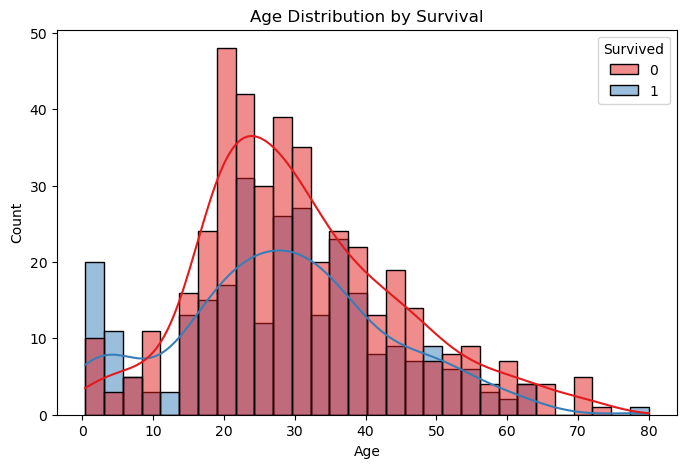

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=train_df,
    x='Age',
    hue='Survived',      
    bins=30,
    kde=True,             
    palette='Set1'
)
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Nhận xét
* Phần lớn khách hàng ở trong độ tuổi từ 20-40 tuổi.
* Ở độ tuổi trẻ (0–20) cho ra khả năng sống sót cao hơn rõ rệt suy ra trẻ em và thanh thiếu niên có tỷ lệ sống cao hơn.
* Ở độ tuổi 20–40 hai đường gần bằng nhau, nhưng đỏ vẫn hơi nhỉnh hơn suy ra nhiều người trưởng thành chết hơn sống.
* Ở độ tuổi 50+ cả hai đường đều thấp, nhưng nhóm không sống sót vẫn chiếm đa số.

Text(0.5, 1.0, 'Fare Distribution by Survival')

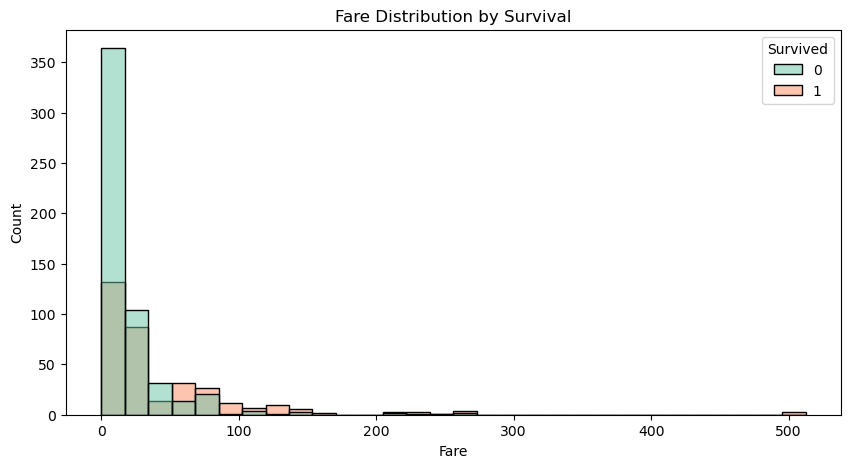

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(data=train_df, x='Fare', hue='Survived', bins=30, palette='Set2')
plt.title('Fare Distribution by Survival')

### Nhận xét:
* Nhìn vào biểu đồ ta thấy được giá vé càng cao thì tỉ lệ sống sót càng cao
* Rất nhiều người mua giá vé thấp, ít người mua giá vé cao

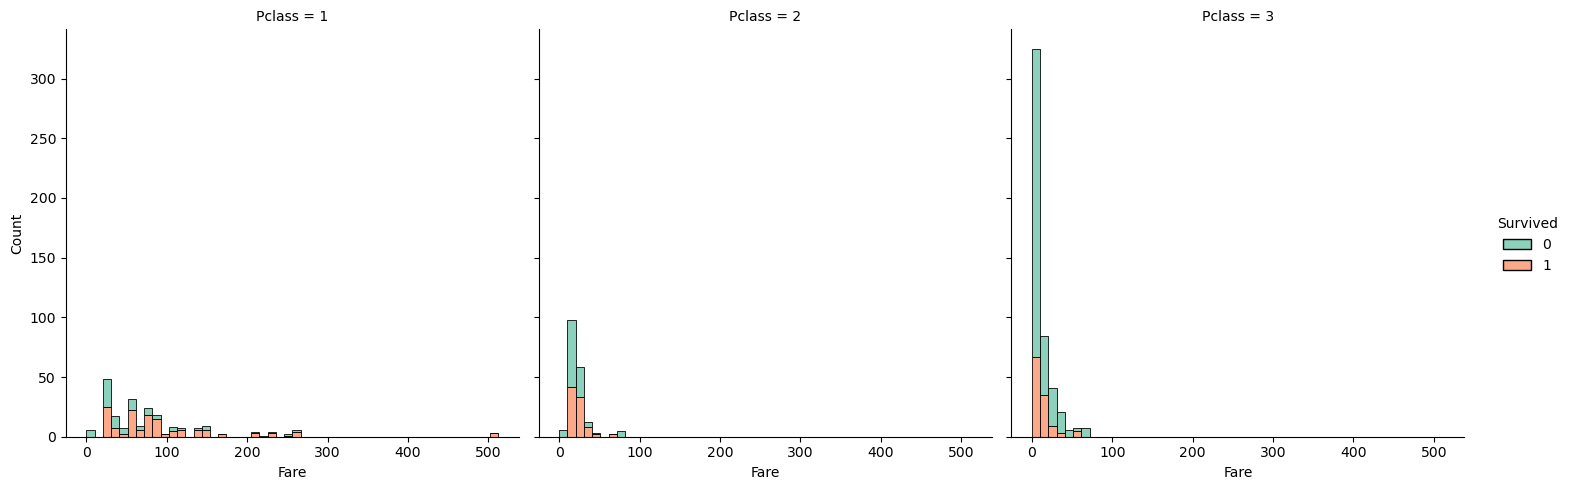

In [12]:
sns.displot(data=train_df, bins=50, x='Fare', col=train_df['Pclass'], hue='Survived', multiple='stack', palette='Set2');

* Ta thấy các Fare càng lớn thì tập trung ở Pclass = 1
* Pclass = 1 cho ra tỉ lệ sống sót cao hơn 2 Pclass còn lại, cho thấy giá vé càng cao sẽ được ở các nhóm vé 1 và tỉ lệ sống sót tốt hơn

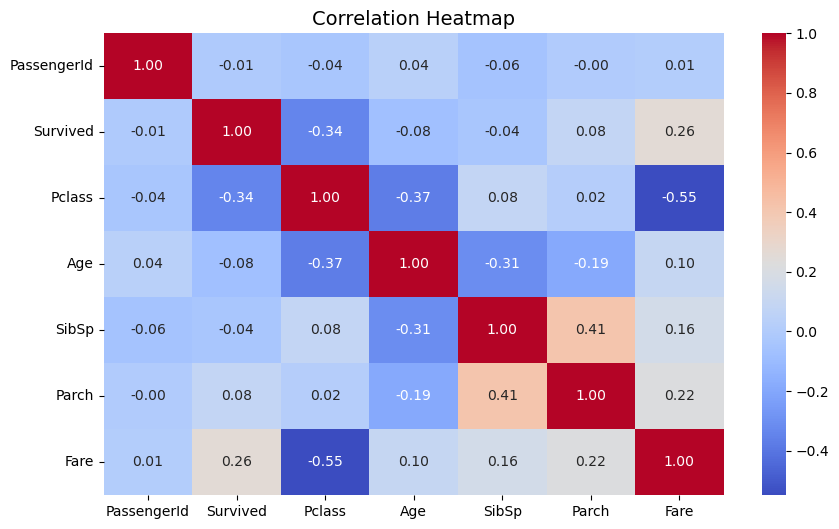

In [13]:
corr = train_df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

### Nhận xét:
* Survived tương quan nghịch với Pclass với -0.34, cho thấy Pclass nhỏ hơn cho ra tỉ lệ sống sót lớn hơn
* Survived tương quan với Fare với 0.26, cho thấy vé đắt hơn thì tỉ lệ sống sót cao hơn
* Pclass tương quan nghịch với Fare -0.55, cho thấy vé Pclass nhỏ hơn thì vé càng đắt hơn
* SibSp tương quan với Parch 0.41, cho thấy người đi chung với anh em thường cũng đi với ba mẹ
* SibSp tương quan nghịch với Age -0.31, cho thấy người càng lớn tuổi thường có xu hương đi một mình hơn

## Features Engineering

### Tạo cột title là danh xưng của các hành khách (Mr, Ms, Mrs,..)

In [14]:
def extract_title(name):
    if pd.isnull(name):
        return "Unknown"
    title = name.split(',')[1].split('.')[0].strip()
    return title

train_df['Title'] = train_df['Name'].apply(extract_title)
test_df['Title'] = test_df['Name'].apply(extract_title)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [15]:
train_df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

### Gom nhóm các title thành group_title

In [16]:
def group_title(title):
    if title in ['Mr']:
        return 'Mr'
    elif title in ['Miss', 'Ms', 'Mlle']:
        return 'Miss'
    elif title in ['Mrs', 'Mme']:
        return 'Mrs'
    elif title in ['Master']:
        return 'Master'
    else:
        return 'Other'
train_df['Group_Title'] = train_df['Title'].apply(group_title)
test_df['Group_Title'] = test_df['Title'].apply(group_title)

train_df['Group_Title'].value_counts()

Group_Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

### Feature Sex biến đổi thành số (male: 1, female: 0)

In [17]:
sex_map = {'male': 1, 'female': 0}

train_df['Sex'] = train_df['Sex'].map(sex_map)
test_df['Sex'] = test_df['Sex'].map(sex_map)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Group_Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr


### Tạo feature Family = SibSp + Parch + 1

In [18]:
train_df['Family'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family'] = test_df['SibSp'] + test_df['Parch'] + 1 

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Group_Title,Family
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,1


### Tạo Feature Deck từ chữ cái đầu tiên cua Cabin

In [19]:
def deck_from_cabin(cabin):
    return cabin[0]
train_df['Deck'] = train_df['Cabin'].apply(lambda x: deck_from_cabin(x) if pd.notnull(x) else 'U')
test_df['Deck'] = test_df['Cabin'].apply(lambda x: deck_from_cabin(x) if pd.notnull(x) else 'U')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Group_Title,Family,Deck
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,2,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,2,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,1,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,2,C
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,1,U


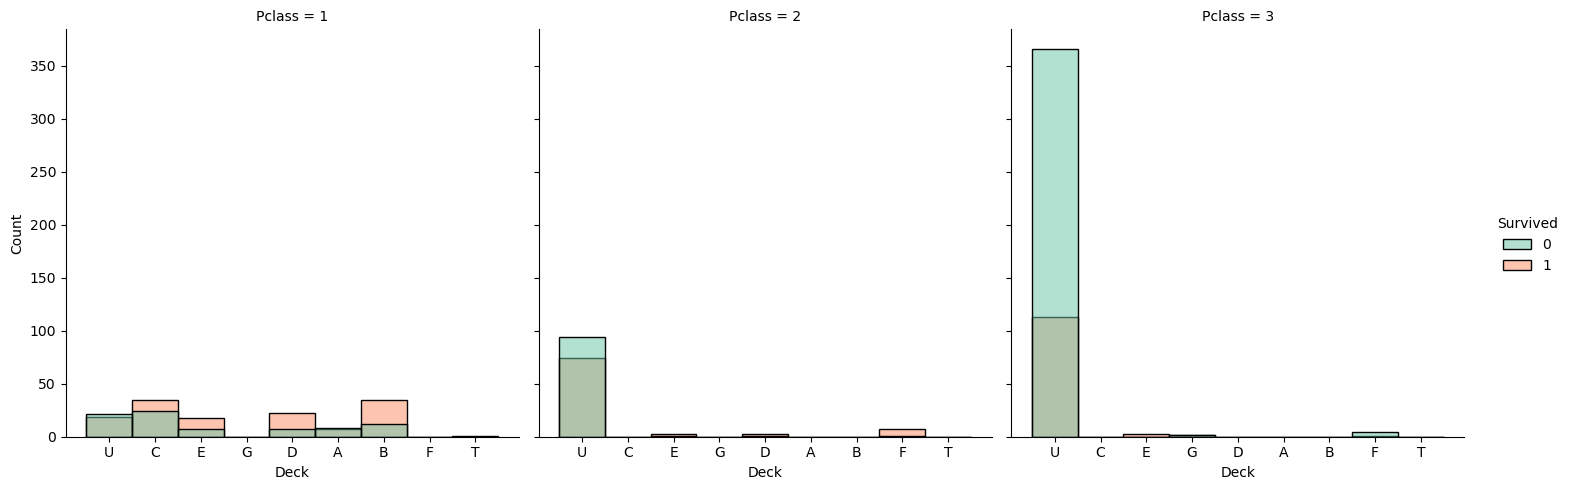

In [20]:
sns.displot(data=train_df, x='Deck', col=train_df['Pclass'], hue="Survived", palette='Set2');

* Ta thấy các hành khách Pclass = 1 đa số có Deck là A,B,C,D,E (Các tầng cao hơn), còn Pclass = 2 hoặc 3 thì đa số ở các tầng thấp hơn
* Ta thấy các hành khách ở Deck U (Unknown) đa số có Pclass là 3 và đa số đều không qua khỏi trong tai họa
* Các hành khách ở Deck D,B,E có tỉ lệ sống sót cao

### Tạo thêm Feature Age_group

In [21]:
def age_group(age):
    if age < 12:
        return 'Child'
    elif 12 <= age < 18:
        return 'Teenager'
    elif 18 <= age < 30:
        return 'Young Adult'
    elif 30 <= age < 50:
        return 'Adult'
    else:
        return 'Senior'
train_df['Age_group'] = train_df['Age'].apply(age_group)
test_df['Age_group'] = test_df['Age'].apply(age_group)

In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Group_Title,Family,Deck,Age_group
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,2,U,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,2,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,1,U,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,2,C,Adult
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,1,U,Adult


## Preprocessing

### Xóa các cột không cần thiết

In [23]:
features_to_drop = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title']

train_df = train_df.drop(columns=features_to_drop)

test_df = test_df.drop(columns=features_to_drop)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Group_Title,Family,Deck,Age_group
0,0,3,1,22.0,7.2500,S,Mr,2,U,Young Adult
1,1,1,0,38.0,71.2833,C,Mrs,2,C,Adult
2,1,3,0,26.0,7.9250,S,Miss,1,U,Young Adult
3,1,1,0,35.0,53.1000,S,Mrs,2,C,Adult
4,0,3,1,35.0,8.0500,S,Mr,1,U,Adult


### processing pipeline

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Chia features thành numeric và categorical
num_features = ['Pclass', 'Age', 'Fare', 'Family']
cat_features = ['Embarked', 'Group_Title', 'Deck', 'Age_group']

# Pipeline cho numeric
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline cho categorical
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Gộp lại
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

## Traning models

In [32]:
x = train_df.drop(columns='Survived')
y = train_df['Survived']

models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000,random_state=42))
    ]),
    'KNeighborsClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(n_estimators=100,max_depth=None,random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(n_estimators=100))
    ])
}

x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, random_state=42)

results = []

submission_df = pd.read_csv('./data/gender_submission.csv')

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4),
    })


results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print(results_df)


                  Model  Accuracy  Precision  Recall  F1 Score
2         Decision Tree    0.8324     0.8333  0.7432    0.7857
0   Logistic Regression    0.8212     0.7838  0.7838    0.7838
3         Random Forest    0.8212     0.7917  0.7703    0.7808
4               XGBoost    0.8212     0.8281  0.7162    0.7681
1  KNeighborsClassifier    0.7933     0.7761  0.7027    0.7376


### Nhận xét:
* Sau bước training ta chọn ra 3 model với score vượt trội
* DecisionTree có accuracy và precision cao nhất
* RandomForest có F1 và Recall cao nhất
* XGBoost có Accuracy, precision và F1 score cao 

## Tuning Hyperparameter

## Sau khi training models, ta chọn ra 3 model được đánh giá cao nhất để tinh chỉnh tham số rồi chọn ra Best model

In [26]:
# Khởi tạo các tham số cho models
# --- DecisionTree ---
param_dt = {
     'model__max_depth': [3, 5, 7, 9, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__criterion': ['gini', 'entropy']
}

# --- RandomForest ---
param_rf = {
    'model__n_estimators': [100, 200, 300],   
    'model__max_depth': [None, 5, 10, 15],    
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],     
    'model__bootstrap': [True, False]      
}

# --- XGBoost ---
param_xgb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 10],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

In [27]:
models_params = [
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', DecisionTreeClassifier(random_state=42))
        ]),
        {
            'model__max_depth': [3, 5, 7, 9, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__criterion': ['gini', 'entropy']
        },
        'Decision Tree'
    ),
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(random_state=42))
        ]),
        {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2],
        },
        'Random Forest'
    ),
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
        ]),
        {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5],
        },
        'XGBoost'
    )
]

for model, params, name in models_params:
    print(f"\nTuning {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best accuracy: {grid.best_score_:.4f}")



Tuning Decision Tree...
Best params for Decision Tree: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best accuracy: 0.8286

Tuning Random Forest...
Best params for Random Forest: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best accuracy: 0.8371

Tuning XGBoost...
Best params for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best accuracy: 0.8286


### Lấy best parameter đi dự đoán trên tập test

In [30]:
best_models = {
    'Decission Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=1, min_samples_split=2))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100))
    ])
}

predictions = {}

for name, model in best_models.items():
    model.fit(x, y)
    y_pred = model.predict(test_df)

    submission = pd.DataFrame({
        'PassengerId': test_df.index + 892,
        'Survived': y_pred
    })
    submission.to_csv(f'./submissions/{name.replace(" ", "_").lower()}submission.csv', index=False)
    print(f'Đã tạp file {name} submission.')




   

Đã tạp file Decission Tree submission.
Đã tạp file Random Forest submission.
Đã tạp file XGBoost submission.


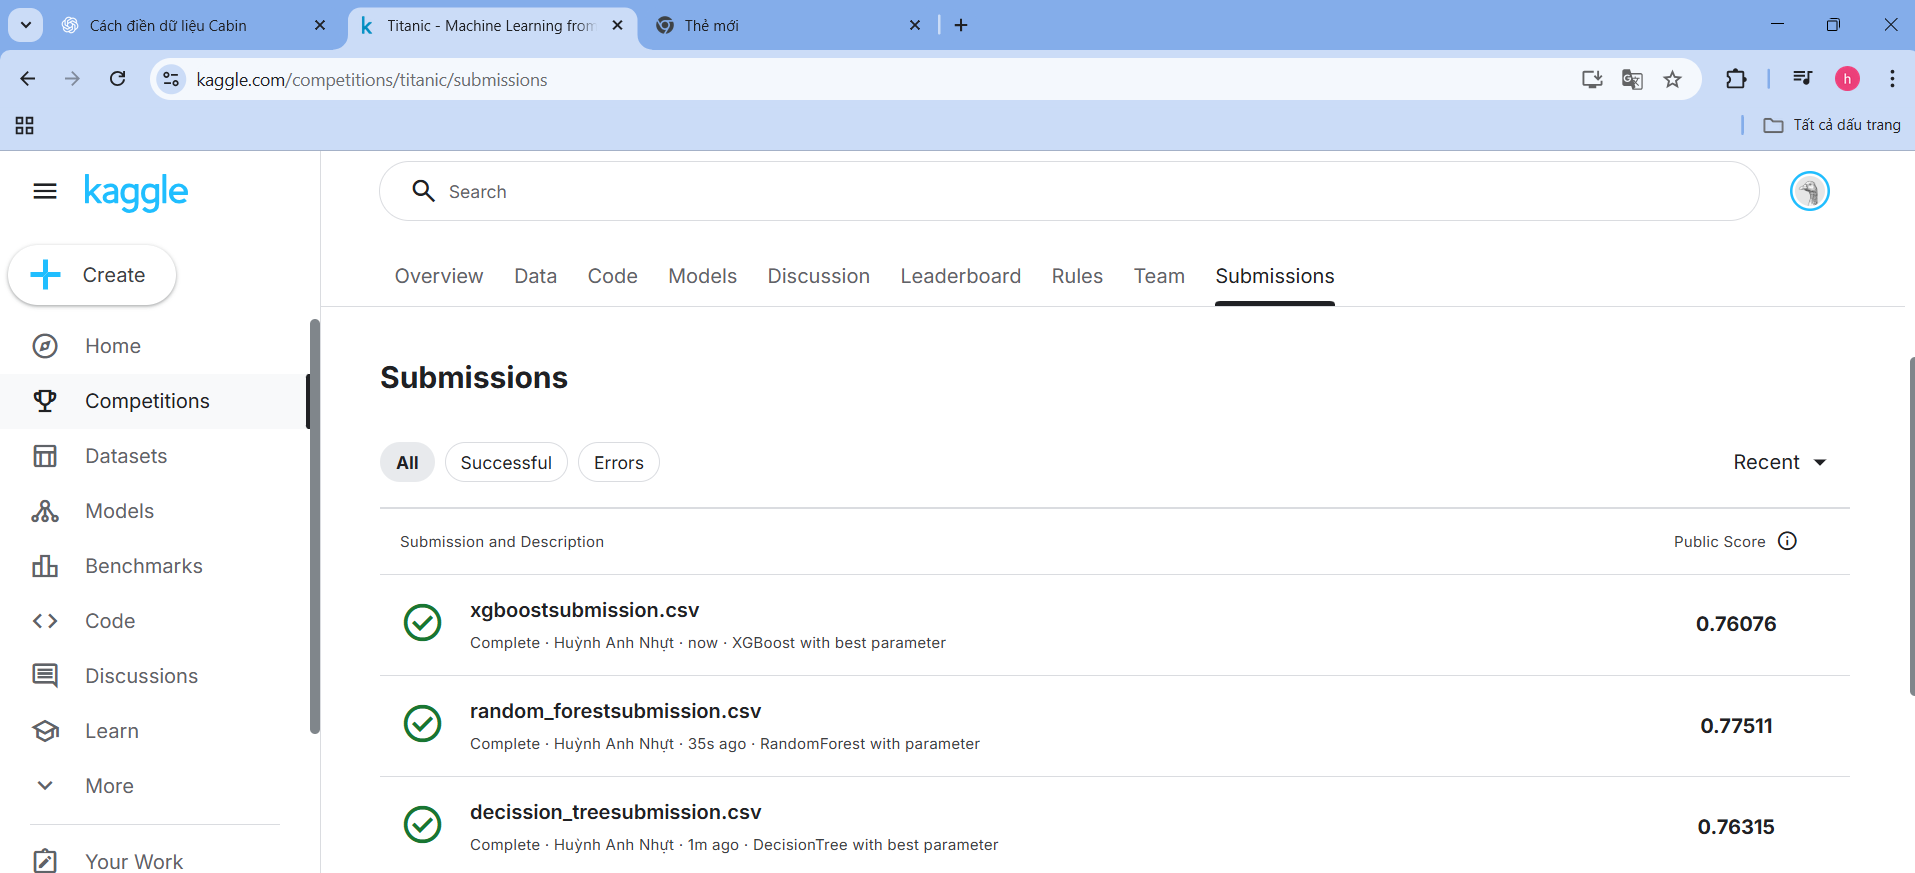

In [31]:
from IPython.display import Image, display

display(Image(filename='./images/minhchung.png'))

### Kết quả
* RandomForest cho ra best accuracy cao nhất và cũng là model dự đoán tốt nhất trên tập test với 0.77511
* XGBoost và DecisionTree với best accuracy thấp hơn đôi chút và điểm dự đoán trên tập test cũng thấp hơn lần lượt là 0.76076 và 0.76315